## Perturbation of sequences
### Dataset: UniProt SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

153

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = orig_pred_val - df[human_label]
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(4859303, 15)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.185032,0.000092,0.000050,0.007873,0.002390,0.804249,0.000229,0.000086,A0A7U3EFD9,Human,A,735,D,0.001539,0.001539
1,0.185391,0.000094,0.000046,0.007566,0.002386,0.804222,0.000207,0.000088,A0A7U3EFD9,Human,V,1022,W,0.001566,0.001566
2,0.183494,0.000093,0.000051,0.007900,0.002362,0.805788,0.000226,0.000086,A0A7U3EFD9,Human,K,1556,R,0.000000,0.000000
3,0.183494,0.000093,0.000051,0.007900,0.002362,0.805788,0.000226,0.000086,A0A7U3EFD9,Human,T,1441,B,0.000000,0.000000
4,0.181761,0.000092,0.000049,0.007865,0.002350,0.807575,0.000223,0.000085,A0A7U3EFD9,Human,Q,1057,P,-0.001787,0.001787


### WIV04 reference sequence

In [6]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniprot/aligned/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniprot_id"] == "WIV04"]
wiv04_df.head()

,uniprot_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,-----MFVFLVLLPLVS---------------------------SQ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [7]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST-----

In [8]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = pos
        
try:
    perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
except: 
    pass

### Distribution of prediction difference values

/tmp/ipykernel_2499550/2860024834.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perturbed_output_df["Human_pred_diff"])


<Figure size 432x288 with 0 Axes>

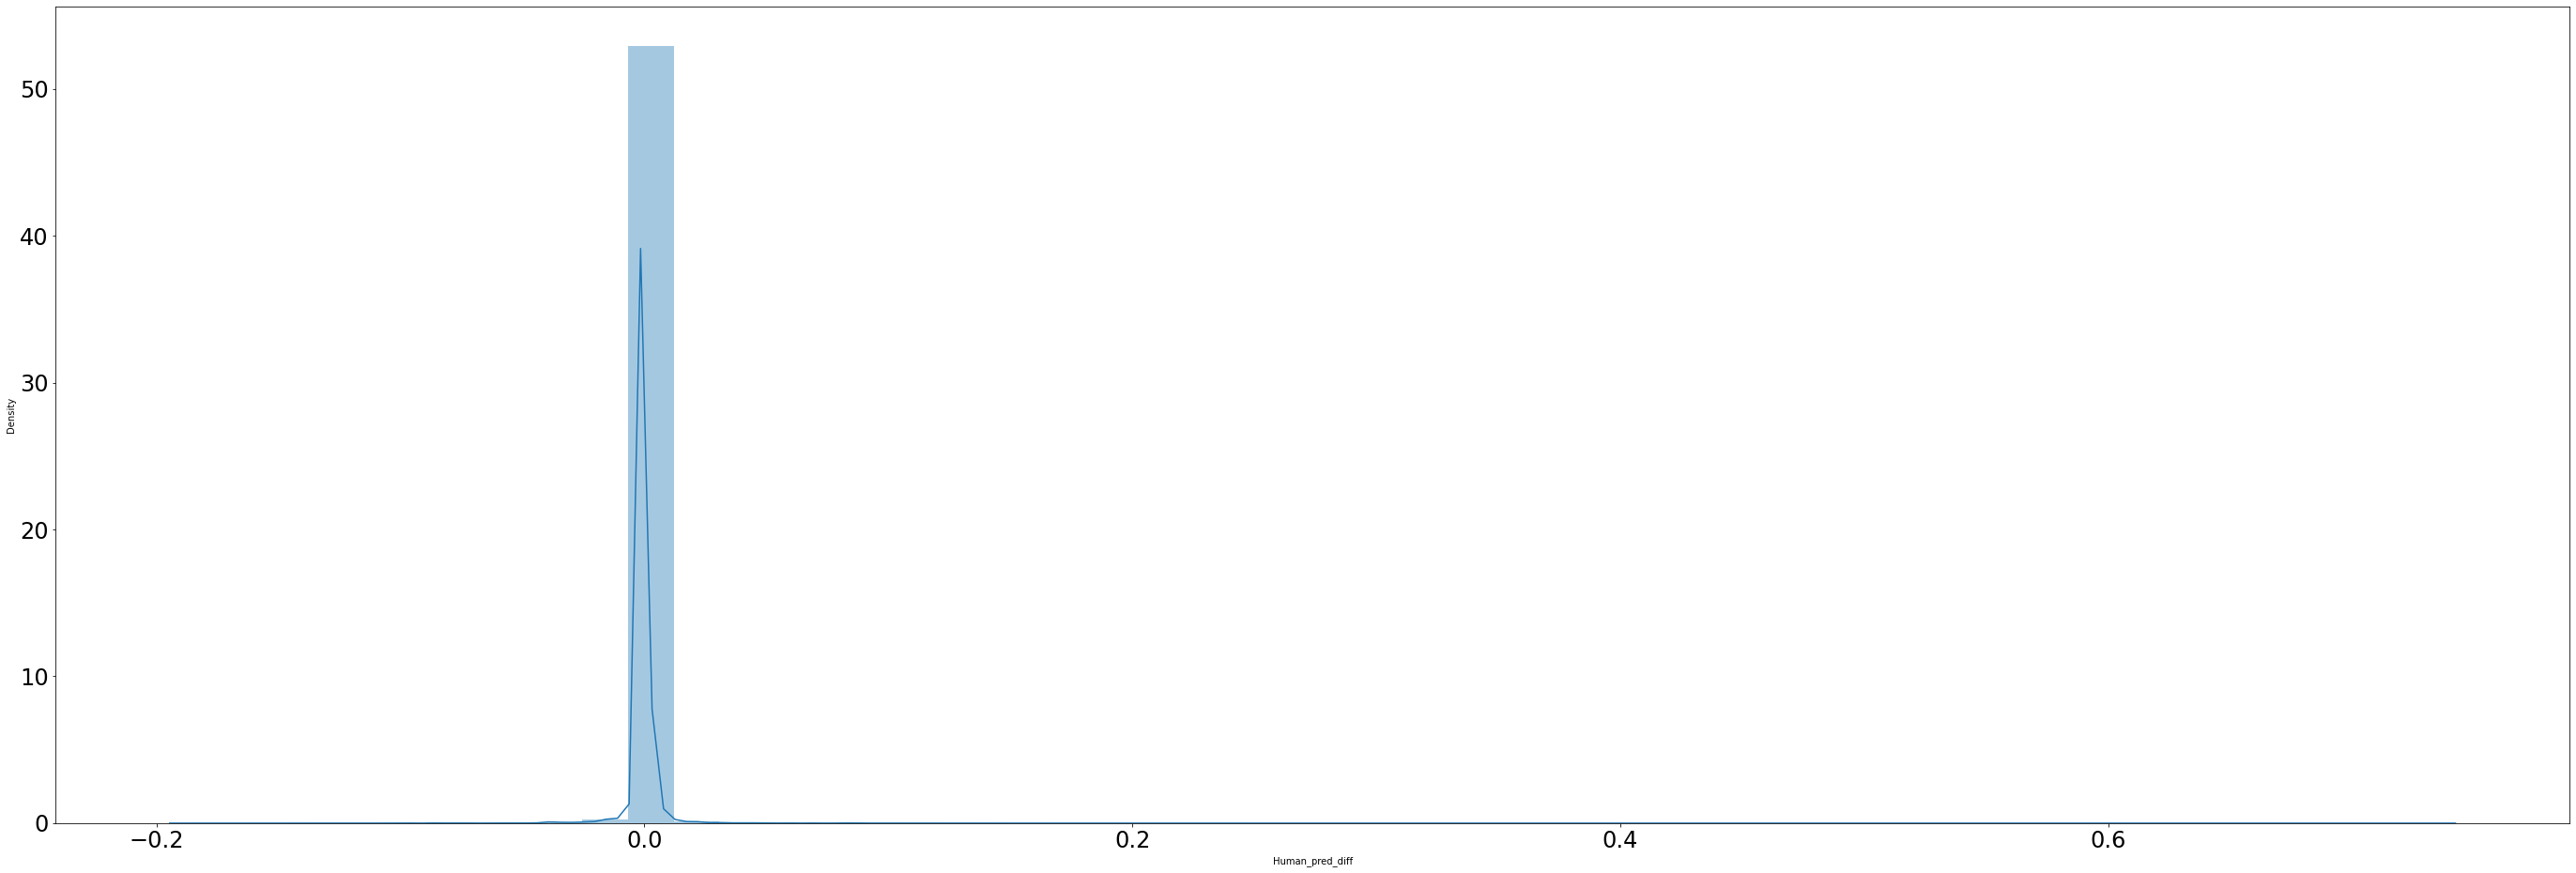

In [9]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(perturbed_output_df["Human_pred_diff"])
plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.193769,-0.115830,797,0.016402
1,-0.115830,-0.037891,3840,0.079024
2,-0.037891,0.040048,4851537,99.840183
3,0.040048,0.117987,2278,0.046879
4,0.117987,0.195927,409,0.008417
5,0.195927,0.273866,84,0.001729
6,0.273866,0.351805,94,0.001934
7,0.351805,0.429744,97,0.001996
8,0.429744,0.507683,22,0.000453
9,0.507683,0.585623,69,0.001420


In [11]:
perturbed_output_df_selected = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] > 0.1]
print(f"Number of sequences = {perturbed_output_df_selected.shape[0]}")
print(f"Number of unique positions = {len(perturbed_output_df_selected['perturb_seq_pos'].unique())}")
print(f"Unique positions = {perturbed_output_df_selected['perturb_seq_pos'].unique()}")

Number of sequences = 2073
Number of unique positions = 52
Unique positions = [584 326 575 303 598 313 467 470 301 296 597 312 240 211 307 294 293 308
 583 468 297 533 287 469 306 106 295 302 299 309 298 305 466 310 304 596
 300 586 291 315 516 292 316 314 311 290 107 289 288 109 258 250]


In [12]:
perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-multi"
perturbation_selected_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_multi.csv")
perturbed_output_df_selected.to_csv(perturbation_selected_output_file_path, index=False)

/tmp/ipykernel_2499550/3825924755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-multi"


### Top 10 perturbations with highest change in prediction probability

In [13]:
perturbed_output_df_selected.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment
15704,0.730549,0.000209,0.000007,0.002721,0.066958,0.197339,0.002096,0.000121,A0A8B6R9R3,Human,D,982,H,0.741501,0.741501,467,sarscov2-uniprot-aligned-multi
7769,0.737268,0.000207,0.000007,0.002592,0.070221,0.187474,0.002115,0.000117,A0A8B1KFH5,Human,D,982,H,0.730722,0.730722,467,sarscov2-uniprot-aligned-multi
288,0.713159,0.000234,0.000008,0.002912,0.064327,0.217184,0.002039,0.000138,A0A7T6THL1,Human,D,982,H,0.700270,0.700270,467,sarscov2-uniprot-aligned-multi
22794,0.698699,0.000234,0.000009,0.003126,0.057415,0.238439,0.001935,0.000143,A0A7U3EE00,Human,D,982,H,0.695072,0.695072,467,sarscov2-uniprot-aligned-multi
7057,0.681495,0.000219,0.000010,0.003482,0.048950,0.264128,0.001582,0.000136,A0A8B6RCX1,Human,D,982,H,0.689983,0.689983,467,sarscov2-uniprot-aligned-multi
4468,0.721859,0.000210,0.000008,0.002827,0.062802,0.210149,0.002023,0.000123,A0A8B1JAK5,Human,D,982,H,0.686985,0.686985,467,sarscov2-uniprot-aligned-multi
3066,0.729742,0.000207,0.000007,0.002690,0.066866,0.198320,0.002049,0.000118,A0A8B1IT83,Human,D,982,H,0.686397,0.686397,467,sarscov2-uniprot-aligned-multi
9068,0.695732,0.000225,0.000009,0.003315,0.057203,0.241477,0.001904,0.000135,A0A8B1KFH5,Human,S,984,H,0.676719,0.676719,469,sarscov2-uniprot-aligned-multi
6772,0.663380,0.000217,0.000010,0.003687,0.046248,0.284692,0.001628,0.000138,A0A8B1JN20,Human,D,982,H,0.671060,0.671060,467,sarscov2-uniprot-aligned-multi
8499,0.725499,0.000256,0.000008,0.002677,0.075164,0.193639,0.002608,0.000148,A0A7U3DWN4,Human,D,982,H,0.670986,0.670986,467,sarscov2-uniprot-aligned-multi


In [14]:
perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
perturbed_output_df_selected.head()

/tmp/ipykernel_2499550/2825421286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment,perturbation_id
2861,0.301073,0.000144,0.000036,0.008373,0.006984,0.682755,0.000515,0.000121,A0A7U3EFD9,Human,I,1193,H,0.123033,0.123033,584,sarscov2-uniprot-aligned-multi,584_H
5243,0.284263,0.000152,0.000036,0.009430,0.006668,0.698849,0.000475,0.000127,A0A7U3EFD9,Human,I,669,H,0.106939,0.106939,326,sarscov2-uniprot-aligned-multi,326_H
5585,0.296935,0.000138,0.000037,0.008561,0.006802,0.686864,0.000546,0.000117,A0A7U3EFD9,Human,A,1184,H,0.118924,0.118924,575,sarscov2-uniprot-aligned-multi,575_H
5944,0.039515,0.000067,0.000049,0.004538,0.000353,0.955381,0.000028,0.000068,A0A7U3EFD9,Human,L,642,X,-0.149593,0.149593,303,sarscov2-uniprot-aligned-multi,303_X
6790,0.307856,0.000121,0.000043,0.007916,0.006665,0.676644,0.000651,0.000105,A0A7U3EFD9,Human,I,1234,H,0.129144,0.129144,598,sarscov2-uniprot-aligned-multi,598_H


In [15]:
mean_diff_df = perturbed_output_df_selected[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [16]:
mean_diff_df = mean_diff_df.reset_index()

In [17]:
mean_diff_df[["perturb_seq_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [18]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,106_H,0.182596,106,H
1,106_X,0.129193,106,X
2,107_X,0.104101,107,X
3,109_H,0.103991,109,H
4,211_H,0.129704,211,H


In [19]:
mean_diff_df[mean_diff_df[["perturb_seq_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token


In [20]:
df = mean_diff_df.pivot(columns="perturb_seq_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [21]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
45,467_H,0.474845,467,H
49,469_H,0.315444,469,H
47,468_H,0.311682,468,H
55,533_W,0.296425,533,W
51,470_H,0.270139,470,H
60,596_H,0.269809,596,H
57,583_H,0.225453,583,H
0,106_H,0.182596,106,H
31,306_X,0.175997,306,X
29,305_X,0.175644,305,X


<Figure size 432x288 with 0 Axes>

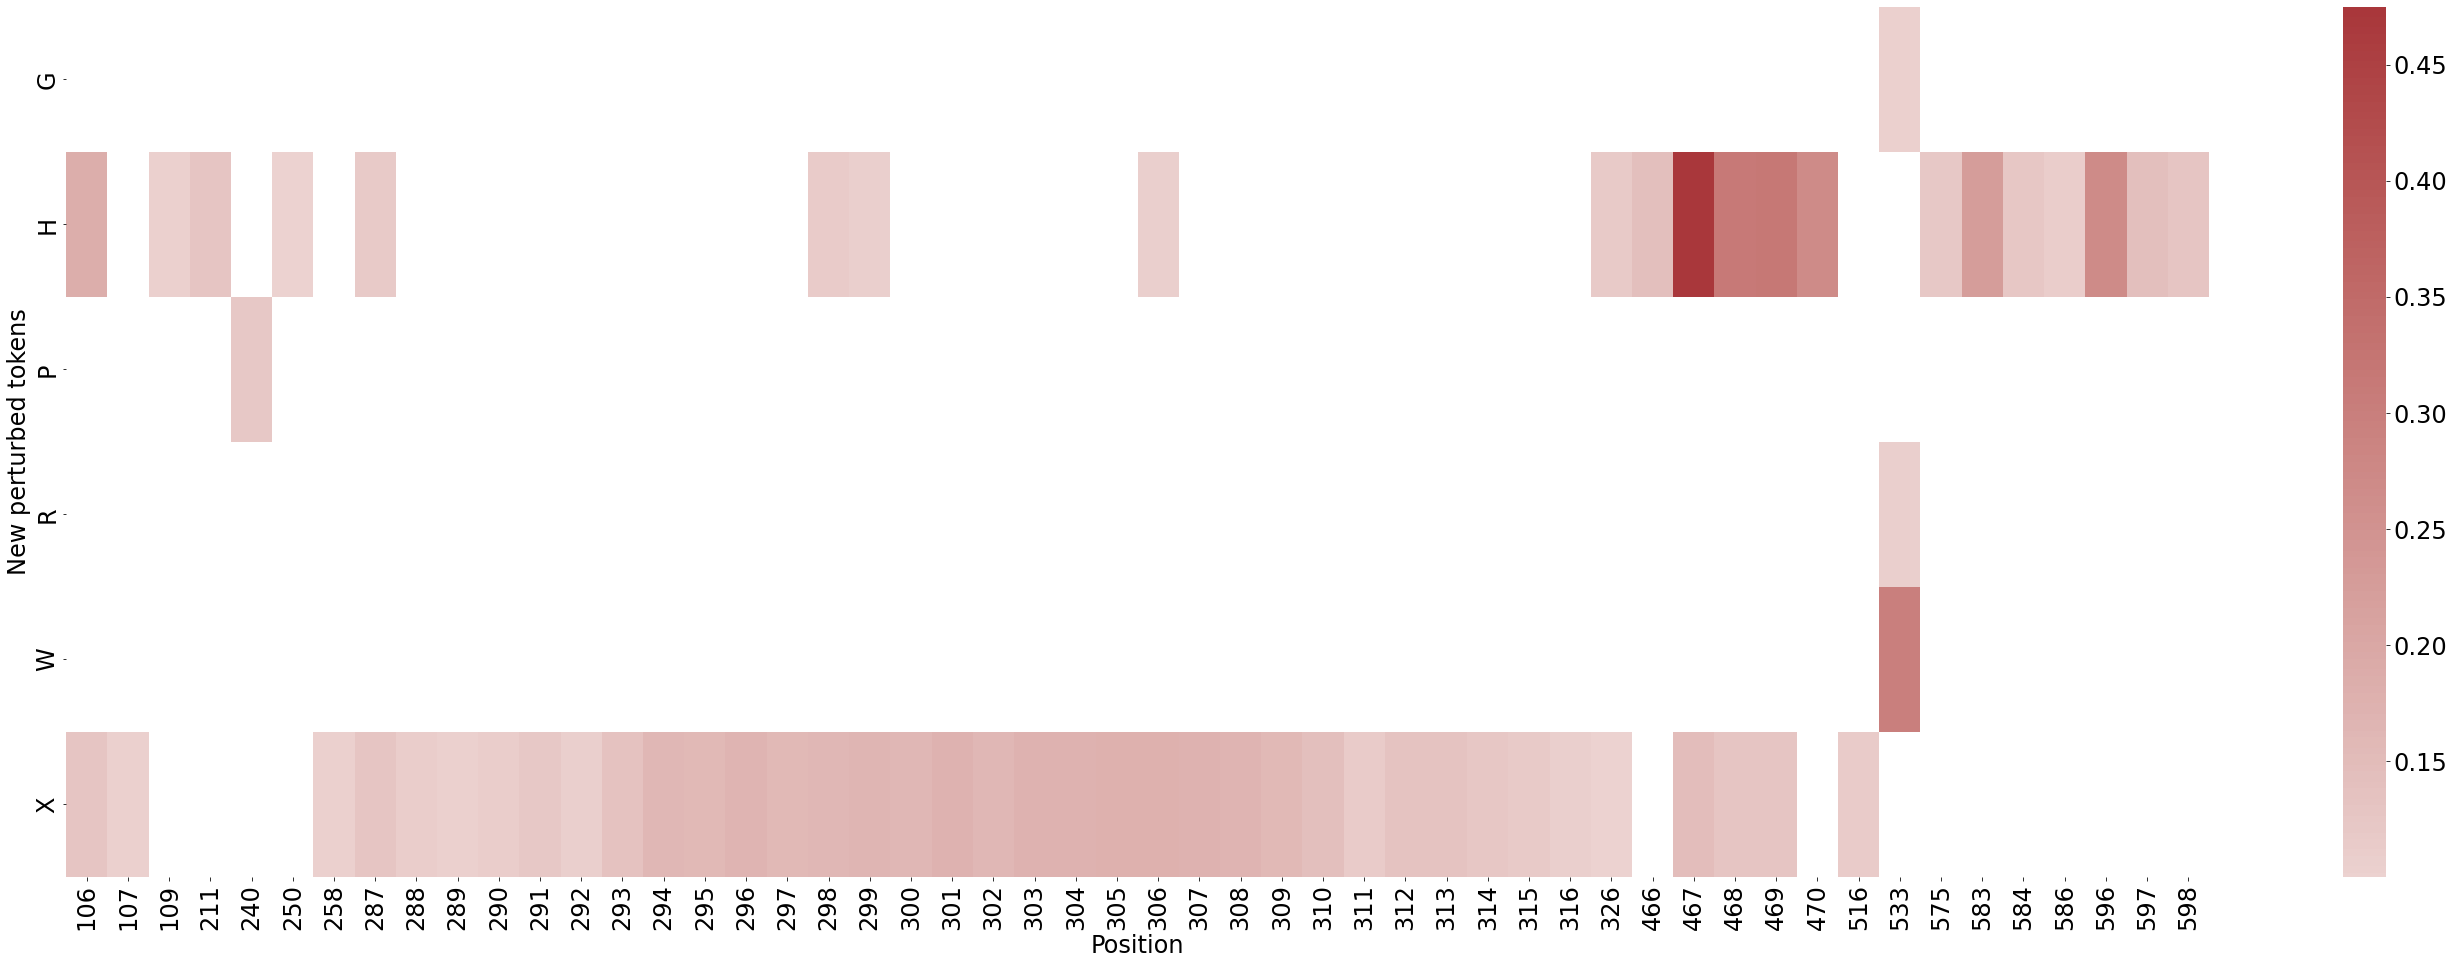

In [22]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [23]:
df.mean(axis=0)

perturb_seq_pos
106    0.155895
107    0.104101
109    0.103991
211    0.129704
240    0.120318
250    0.100549
258    0.101665
287    0.123629
288    0.110758
289    0.103595
290    0.110658
291    0.121343
292    0.107019
293    0.136737
294    0.160446
295    0.158207
296    0.167465
297    0.160122
298    0.137691
299    0.134593
300    0.162594
301    0.170472
302    0.161432
303    0.173288
304    0.173975
305    0.175644
306    0.140306
307    0.172846
308    0.169893
309    0.156783
310    0.144224
311    0.114072
312    0.132208
313    0.133001
314    0.125335
315    0.118941
316    0.107022
326    0.108879
466    0.145287
467    0.311627
468    0.219943
469    0.222392
470    0.270139
516    0.115213
533    0.169517
575    0.121014
583    0.225453
584    0.125962
586    0.111627
596    0.269809
597    0.142788
598    0.129782
dtype: float64

<Figure size 432x288 with 0 Axes>

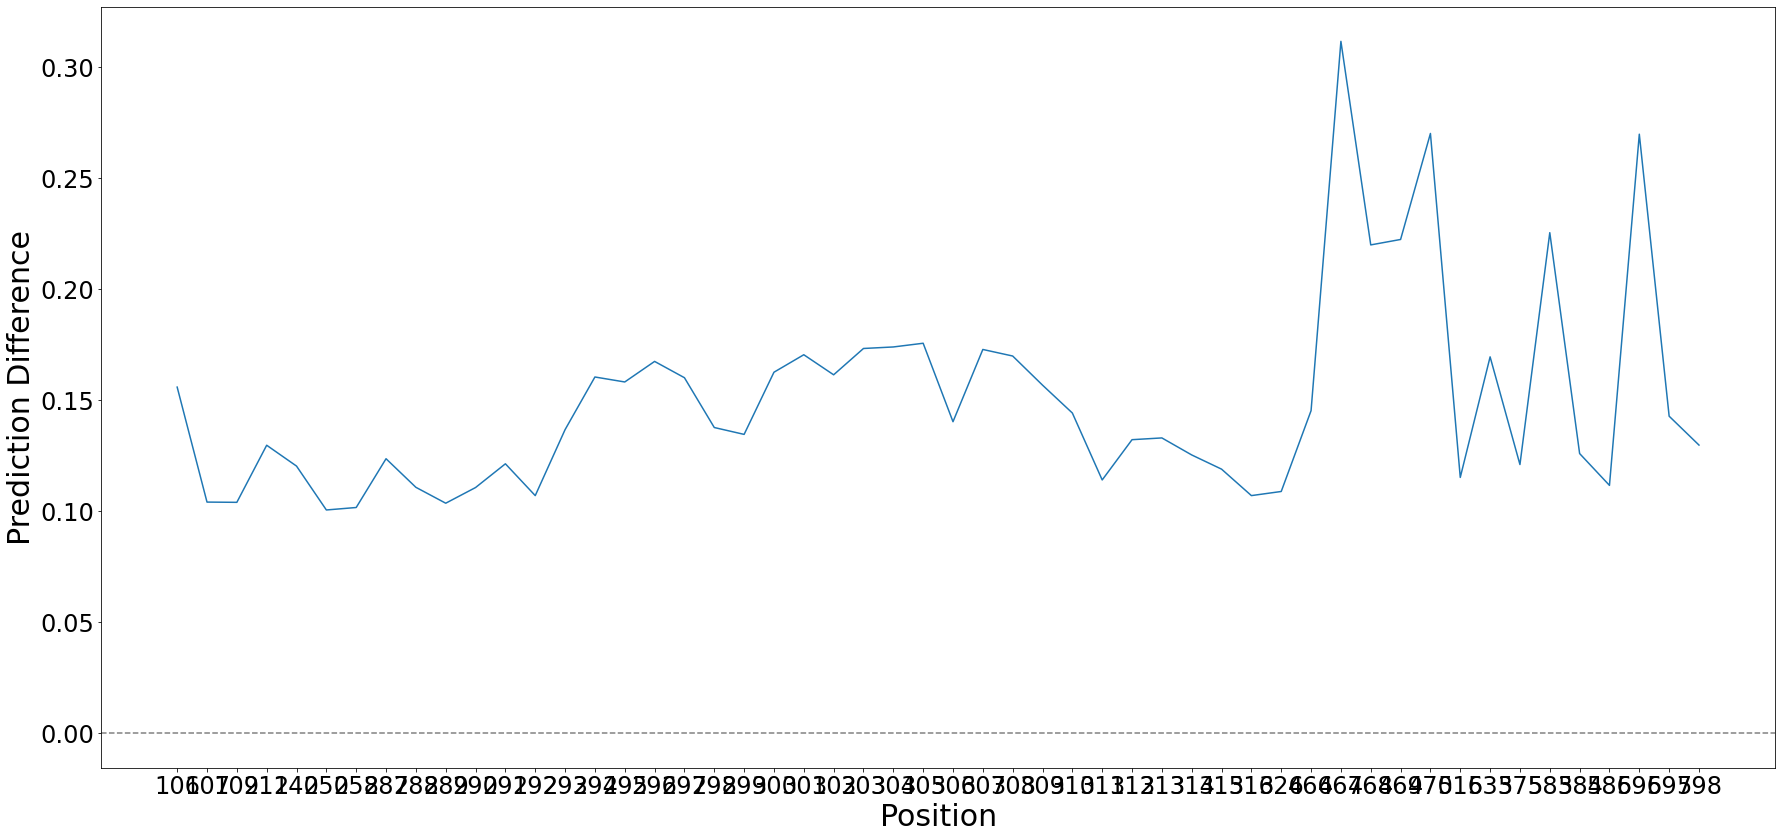

In [24]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
#ax.set_xlim(0, 1273)
plt.show()